In [1]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
proj_path = '/content/drive/MyDrive/DL_project/gender_classification'
os.chdir(proj_path)

### Import Library

In [26]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import glob
from tensorflow import random
from zipfile import ZipFile
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import math
from keras.optimizers import Adam
import shutil
import tensorflow as tf
from sklearn.metrics import accuracy_score
from keras.models import Model
import glob
from keras.applications.vgg16 import VGG16, preprocess_input

In [27]:
#file_name = 'celeb_small.zip'

# Unzip the file
#with ZipFile(file_name,"r") as zip_file_hndl:
#    zip_file_hndl.extractall(proj_path)

In [28]:
ls

celeb_small/                   vggmodel_finetuned.h5
celeb_small.zip                vggmodel_finetuned_weights.best.hdf5
__MACOSX/                      vggmodel_old.h5
transfer_learning_vgg_1.ipynb  vggmodel_weights_old.best.hdf5
transfer_learning_vgg.ipynb


In [29]:
#set a seed
seed = 1
np.random.seed(seed)
random.set_seed(seed)

### Prepare Traning Data

In [30]:
# Dir path where all the images are present.
folder_path = os.path.join(proj_path, 'celeb_small')
img_paths = glob.glob(os.path.join(folder_path, '*.jpg'))

In [31]:
# Create a dataframe with image file paths and labels
data = []
for img_path in img_paths:
    img_file_name = os.path.basename(img_path)
    label = img_file_name.split('.')[0]  # Image file names  are in the format "label_name.id.jpg"
    data.append({'img_path': img_path, 'label': label})

df = pd.DataFrame(data)
df.head()

,img_path,label
0,/content/drive/MyDrive/DL_project/gender_class...,female
1,/content/drive/MyDrive/DL_project/gender_class...,man
2,/content/drive/MyDrive/DL_project/gender_class...,man
3,/content/drive/MyDrive/DL_project/gender_class...,man
4,/content/drive/MyDrive/DL_project/gender_class...,female


In [32]:
num_classes = df['label'].nunique()
num_classes

2

In [33]:
df.shape

(3801, 2)

In [34]:
# 80% data for training, 10% data for validation and 10% data for test.
train_df, rem_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=100, shuffle=True)

In [35]:
train_df['label'].value_counts()

female    1527
man       1513
Name: label, dtype: int64

In [36]:
# 10% data for validation and 10% data for test.
val_df, test_df = train_test_split(rem_df, test_size=0.5, stratify=rem_df['label'], random_state=100, shuffle=True)

In [37]:
val_df['label'].value_counts()

female    191
man       189
Name: label, dtype: int64

In [38]:
test_df['label'].value_counts()

female    191
man       190
Name: label, dtype: int64

### Visualize the data

In [39]:
sample_df = train_df.sample(15)
sample_img_paths = sample_df['img_path'].to_list()
sample_img_labels = sample_df['label'].to_list()

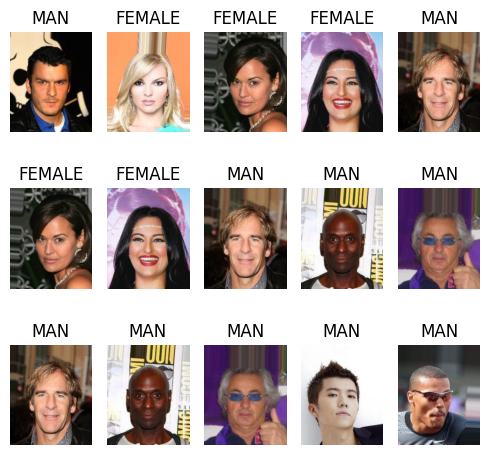

In [40]:
# Visualize the batch of images
fig, axes = plt.subplots(3, 5, figsize=(5, 5))

for i in range(3):
    for j in range(5):
        image = Image.open(sample_img_paths[i*2+j])
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{sample_img_labels[i*2+j].upper()}")

plt.tight_layout()
plt.show()

### Build model

#### Using Transfer learning from VGG16

In [41]:
# Input shape required by VGG16
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_CHANNELS=3
INP_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
IMAGE_SIZE=(IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE = 128

In [42]:
# Load the pre-trained VGGNet model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INP_SHAPE)

In [43]:
# Freeze the pre-trained layers
for layer in vgg_model.layers:
    layer.trainable = False

In [44]:
# Create a new model
model = Sequential()
model.add(vgg_model)

# Add a custom output layer
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))  # num_classes is the number of classes in your dataset

In [45]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 14,846,530
Trainable params: 131,842
Non-trainable params: 14,714,688
_________________________________________________________________


In [47]:
vggmodel_weights_filepath = 'vggmodel_weights.best.hdf5'
if os.path.exists(vggmodel_weights_filepath):
    model.load_weights(vggmodel_weights_filepath)

In [48]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Define Callbacks

In [49]:
callbacks = []

# Saving checkpoints
checkpoint = ModelCheckpoint(vggmodel_weights_filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks.append(checkpoint)

In [50]:
# Define early_stopping.
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1)
callbacks.append(early_stopping)

In [51]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.1,
                              patience=3)
callbacks.append(reduce_lr)

### Training Generator

In [52]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   #brightness_range=[0.5, 1],
                                   horizontal_flip=True)


train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='img_path',
                                                    y_col='label',
                                                    seed=seed,
                                                    # all images will be resized to configured target size,
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    )


Found 3040 validated image filenames belonging to 2 classes.


### Validation Generator

In [53]:
# preprocess_input from VGG16
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                x_col='img_path',
                                                y_col='label',
                                                seed=seed,
                                                # all images will be resized to configured target size,
                                                target_size=IMAGE_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                )

Found 380 validated image filenames belonging to 2 classes.


### Check the working of training generator

In [54]:
class_indices = train_generator.class_indices
label_names = list(class_indices.keys())

In [55]:
class_indices

{'female': 0, 'man': 1}

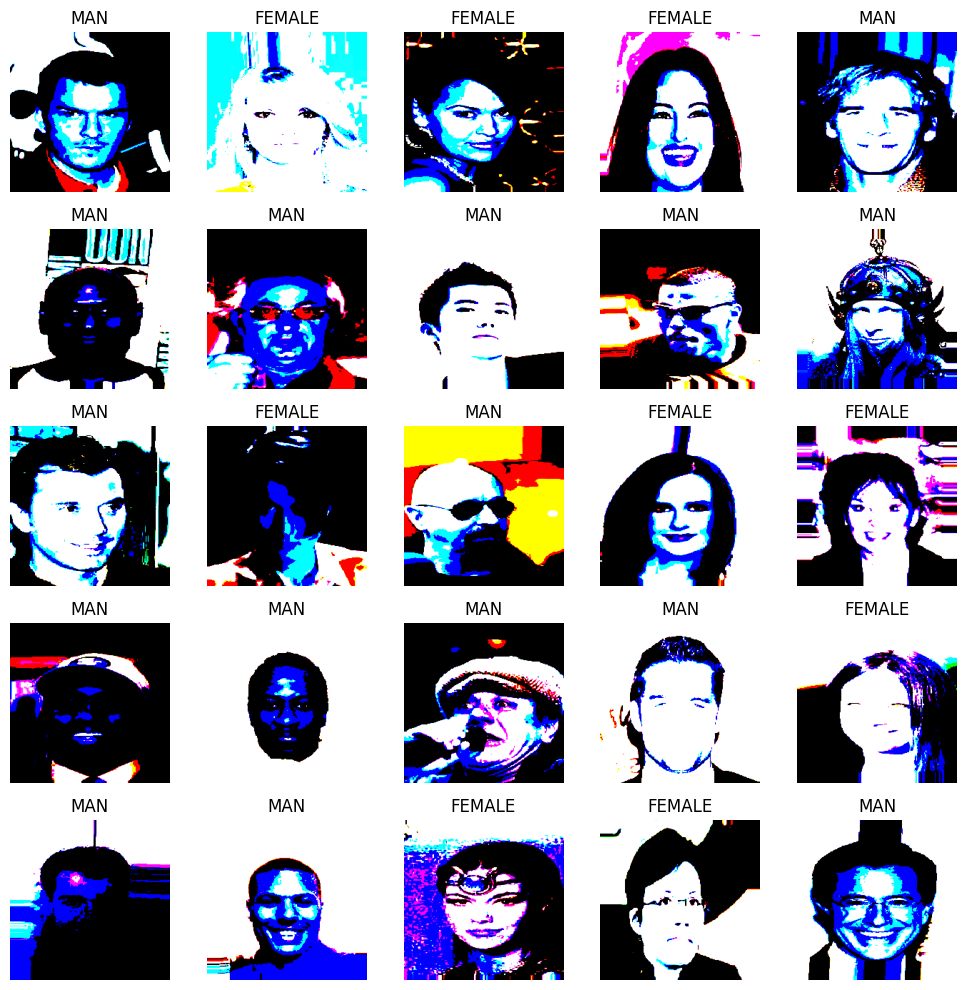

In [56]:
# Retrieve a batch of images from the generator
batch_images, batch_labels = train_generator.next()
batch_label_names = [label_names[np.argmax(label)] for label in batch_labels]

# Visualize the batch of images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        # Change the channel ordering from BGR to RGB.
        #original_img = batch_images[i*5+j][..., ::-1]
        # Clip the image values to [0, 255]
        #original_img = np.clip(original_img, 0, 255)

        axes[i, j].imshow(batch_images[i*5+j])
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{batch_label_names[i*5 + j].upper()}")

plt.tight_layout()
plt.show()

### Fit Model

In [57]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.7839 
Epoch 1: val_accuracy improved from -inf to 0.90789, saving model to vggmodel_weights.best.hdf5
24/24 [==============================] - 835s 35s/step - loss: 0.7025 - accuracy: 0.7839 - val_loss: 0.2614 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.8970
Epoch 2: val_accuracy did not improve from 0.90789
24/24 [==============================] - 138s 6s/step - loss: 0.3094 - accuracy: 0.8970 - val_loss: 0.2654 - val_accuracy: 0.9053 - lr: 0.0010
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9115
Epoch 3: val_accuracy improved from 0.90789 to 0.93158, saving model to vggmodel_weights.best.hdf5
24/24 [==============================] - 139s 6s/step - loss: 0.2353 - accuracy: 0.9115 - val_loss: 0.2124 - val_accuracy: 0.9316 - lr: 0.0010
Epoch 4/20
24/24 [=======================

In [58]:
model.save("vggmodel.h5")

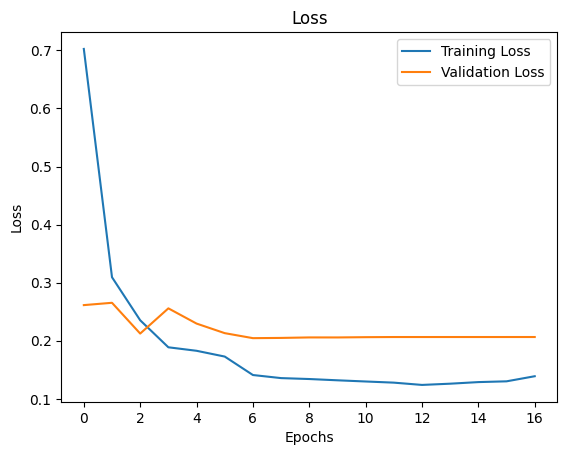

In [61]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

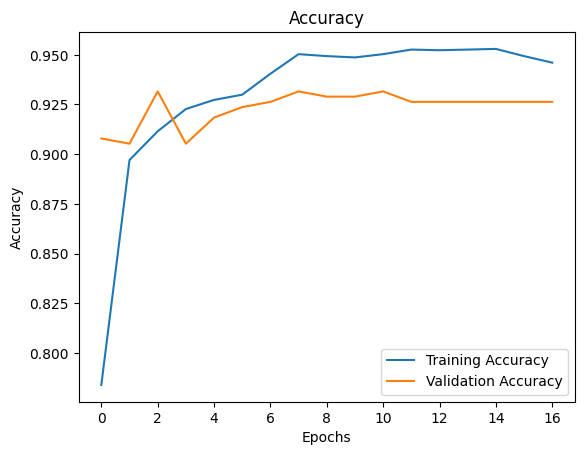

In [62]:
# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Test generator

In [59]:
# preprocess_input from VGG16
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col='img_path',
                                                  y_col='label',
                                                  seed=seed,
                                                  # all images will be resized to configured target size,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False
                                                )

Found 381 validated image filenames belonging to 2 classes.


In [60]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)

# Get the predicted class labels
predicted_labels = tf.argmax(predictions, axis=1)
test_df['predicted_label'] = predicted_labels.numpy()

# Get the ground truth labels
true_labels = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print("Accuracy: {:.2f}%".format(accuracy * 100))


3/3 [==============================] - 69s 32s/step
Accuracy: 88.19%
